
<div>
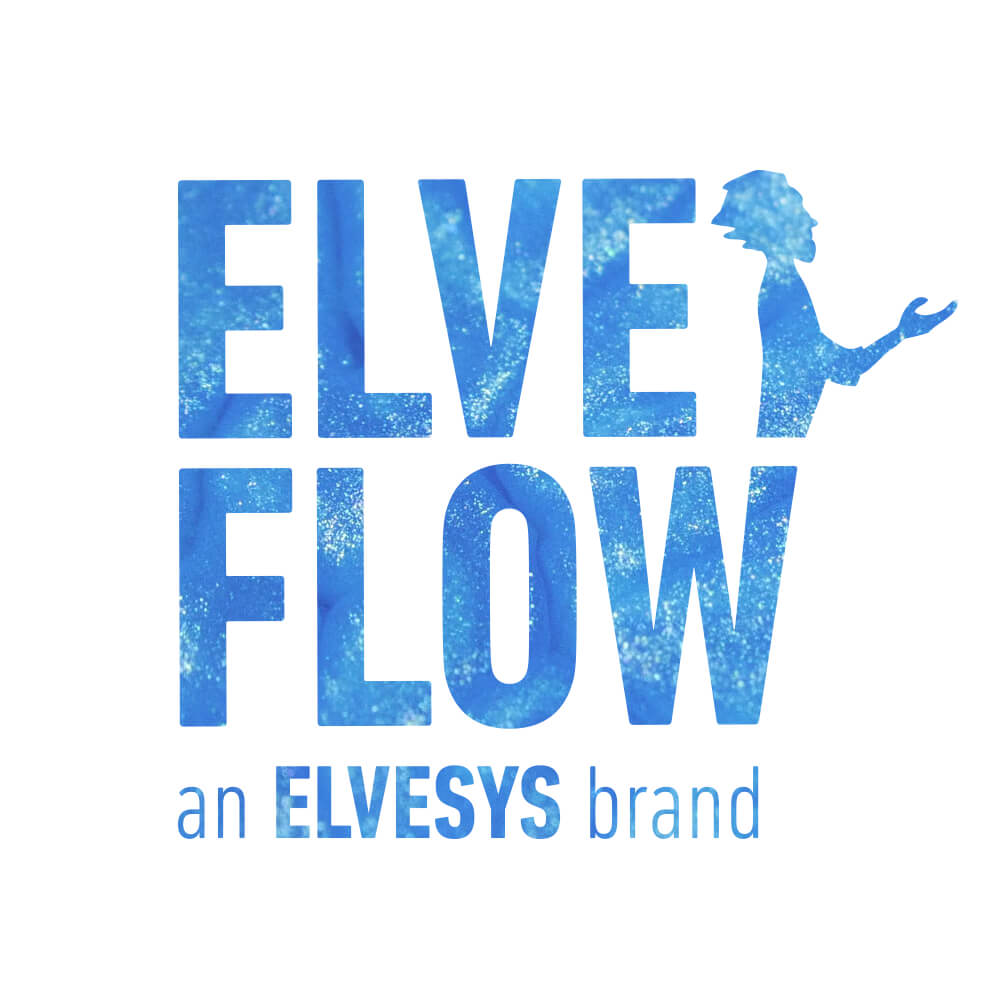
</div>


# Elveflow SDK Tutorial Part 2: Flow Control

In this second part of the tutorial, the basic process for setting up flow control is shown, first with a housemade feedback loop cod, then with advance features of the SDK. It is assumed that you are familiarized with all the basic operating of your system and that you have correctly followed the first part of the tutorial. 

At the end of this tutorial, you should be able to control both the pressure and the flow of a microfluidic setup.

Also, before starting with this introduction, make sure you have read all the documentation related to your purchased products. Disregarding that information could **risk damaging** the equipment. In case you don't have a copy, you can download all the documents from our [website](https://support.elveflow.com/support/home).

The content of this chapter of the tutorial is the following:
1. Flow and pressure in microfluidic systems
2. PI controller
    - PI basics
    - PI software
    - Parameters tuning
3. SDK remote PID control
4. Conclusion

This tutorial has been written and tested using Windows 10, 64bits, Python 3.8.8, Jupyter Notebook 6.3.0 in October, 2021,with the ESI and SDK version V3.6.0.
The pressure controller is an OB1 MK3+ and the flow sensor a FS5D.

## 2.1 Flow and pressure in microfluidic systems
Flow control is achieved by adjusting the pressure being sent in a microfluidic setup, in our case via the OB1 pressure controller. The relationship between pressure and flow is therefore vital in microfluidics.

In laminar regimes (and therefore most microfluidic applications), the flow $Q$ in the system is actually linearly related to the pressure difference $\Delta P$ in the system, via a quantity commonly called microfluidic resistance $R$:

$$\Delta P=R*Q$$

Ideally, a system could be controlled in flow once its resistance is known, by simply applying the corresponding pressure. However this approach does not include drifts, pressure fluctuation in the or ageing of the microfluidic setup.

**Note:**
1. The resistance $R$ can either be determined experimentally by recording a pressure ramp or [theoretically](https://en.wikipedia.org/wiki/Hagen%E2%80%93Poiseuille_equation) in knowing the dimension of the system and the liquid being used.
2. For non laminar flows **and** for damaged flow sensor the flow behavior becomes [parabolic](https://en.wikipedia.org/wiki/Darcy%E2%80%93Weisbach_equation).

In order to have robust flow control, a more generic feedback loop will be used.

## 2.1 PI controller

### 2.1.1 PI basics
The PI Controller or Proportional-Integrative Controller is a basic linear controller, yet powerful for lot of situations, which makes the output of the controlled system to follow a desired curve of values, called reference, and ensures that the system properly works and that it is stable for the operating expected situation.

To achieve this control of the system's output, it takes the current system's output value, calculates the difference to the reference (the desired output), which is called **error**, and makes some operations with it.

The operations for a basic PI Control are two: the proportional term calculus and the integrative term calculus. 
- The proportional term corresponds to the **current** error multiplied by a proportional gain. The larger this gain is, the more aggressive the control will react. For an instant *k*:
$$ P_{term} = K_{p}  (y_{k}-y_{k,ref})$$
- The integrative term corresponds to the **accumulated** error multiplied by an integrative gain. The larger this gain is, the faster the control will react to the changes between the real output and the desired one. For an instant *k*:
$$ I_{term} = K_{i}  \sum \limits _{k=0} ^{k} {(y_{k}-y_{k,ref})}$$

**Note.** Usually, the integrative gain is expressed as integrative time which is related to the integrative gain through the sampling period of the controlling system, but it is shown here this way as may be considered more understandable with gains.

### 2.1.2 PI software

The PI code is only a translation of the previous equations to the Python language:

    error = p_sens - p_ref
    i_error += error
    
    P_val = K_P * error
    I_val = K_I * i_error
    p_control = P_val + I_val

In the next code cell you can run the initialization of the system. After it, you will find the place where you can put your controller code inside the main execution routine that was shown in the previous chapter of this tutorial.

**Before running the following code**, change all the paths, OB1 values and sensor values to match your system.


In [3]:
# INITIALIZATION

# Tested with Python 3.5.1 (IDE Eclipse V4.5.2 + Pydev V5.0.0)
# Add python_xx and python_xx/DLL to the project path
# coding: utf8

import sys
from email.header import UTF8

sys.path.append('C:/dev/SDK/DLL64/DLL64') # Add the path of the library here
sys.path.append('C:/dev/SDK/Python_64') # Add the path of the LoadElveflow.py

from ctypes import *

from array import array
from Elveflow64 import *

import time
import matplotlib.pyplot as plt

#
# Initialization of OB1 ( ! ! ! REMEMBER TO USE .encode('ascii') ! ! ! )
#
Instr_ID=c_int32()
print("Instrument name and regulator types are hardcoded in the Python script")

# See User Guide to determine regulator types and NIMAX to determine the instrument name 
error=OB1_Initialization('01BECD3F'.encode('ascii'),3,2,0,0,byref(Instr_ID)) 

# All functions will return error codes to help you to debug your code, for further information refer to User Guide
print('error:%d' % error)
print("OB1 ID: %d" % Instr_ID.value)

# Add one digital flow sensor with water calibration (OB1 MK3+ only), all information to declare sensors 
# are described in the User Guide
error=OB1_Add_Sens(Instr_ID, 2, 4, 1, 0, 7, 0)
# (CustomSens_Voltage_5_to_25 only works with CustomSensors and OB1 from 2020 and after)
print('error add digit flow sensor:%d' % error)

Calib=(c_double*1000)() # Always define array this way, calibration should have 1000 elements

while True:
    answer=input('Select calibration type (default, load, new ) : ')
    Calib_path='C:\\Users\\Public\\Desktop\\Calibration\\Calib.txt'
    if answer=='default':
        error=Elveflow_Calibration_Default (byref(Calib),1000)
        break
    if answer=='load':
        error=Elveflow_Calibration_Load (Calib_path.encode('ascii'), byref(Calib), 1000)
        break
        
    if answer=='new':
        OB1_Calib (Instr_ID.value, Calib, 1000)
        error=Elveflow_Calibration_Save(Calib_path.encode('ascii'), byref(Calib), 1000)
        print ('calib saved in %s' % Calib_path.encode('ascii'))
        break
    else:
        print("Not recognized command.")

if error==0:
    print("Done.")

Instrument name and regulator types are hardcoded in the Python script
error:-301706
OB1 ID: -1
error add digit flow sensor:-8003
Select calibration type (default, load, new ) : default
Done.


The code for controlling the system would be something like the following code if you do it with **a custom controller**.
You have first two functions which run the control over the system and, after that, you can find a code in which you can change the values of the parameters of the controller. 

If your microfluidic circuit is not very hydraulically resistive, you may need to add some flow resistance to it in order to make use of the whole ranges of your flow sensor and pressure regulators. 

Remember that each microfluidic system needs a different PI Controller tuning, thus, the results you will have may be different to the ones obtained with my testing setup. Try the proposed parameters values or change those values if you are confident, but avoid to make huge changes on the parameters at a time to maintain the system within safety limits.

In [2]:
period = 0.1 # 10Hz
p_error = 0
i_error = 0
meas_flow = c_double()

def pid_run():
    global p_error
    global i_error
    start_t = time.time() # <- This must be close to the routine
    last_t = start_t
    # Main routine
    while True:
        # Get the current output
        error=OB1_Get_Sens_Data(Instr_ID.value, fs_channel, 1, byref(meas_flow))
        flow_list.append(meas_flow.value)

        # Calculate the mathematical error
        p_error = ref_flow - meas_flow.value
        i_error += p_error
        # PI Controller equations
        P_val = K_p * p_error
        I_val = K_i * i_error
        p_control = P_val + I_val
        p_control = max(p_min, min(p_max, p_control)) # Safety saturation

        error_list.append(p_error)
        control_list.append(p_control)

        p_control=c_double( float(p_control) ) # Convert to c_double
        error=OB1_Set_Press(Instr_ID.value, p_channel, p_control, byref(Calib), 1000) # Return error message

        # Check if the elapsed time match the time limit
        if (time.time() - start_t) > experiment_t:
            break
        # Wait until desired period time
        sleep_t = period - (time.time() - last_t)
        if sleep_t > 0:
            time.sleep( sleep_t )
        last_t = time.time() # And update the last time

    # Turn off the pressure
    p_control = 0.0
    error=OB1_Set_Press(Instr_ID.value, p_channel, p_control, byref(Calib), 1000) # Return error message

    
def plot():
    # Plot the signals
    plt.rcParams['axes.grid'] = True
    fig=plt.figure()
    fig.suptitle("Microfluidic Circuit Control at {0:.2f}Hz".format(1/period))

    plt.subplot(2,1,1)
    plt.plot( flow_list )
    plt.ylabel('flow [uL/min]')
    plt.subplot(2,1,2)
    plt.plot( control_list )
    plt.ylabel('pressure [mbar]')

    
def run():
    pid_run()
    plot()

### 2.1.3 Parameters tuning

Change the following values to tune the controller for your system. You can also change the reference value and the experiment execution time by some values more useful for your application. If the system follows your reference too slowly, you may increase the proportional and/or the integrative gain. If it is too aggressive, the contrary. Feel free to play with them by changing the values in small steps.

Also check that the control maximum and minimum values are good for your system.

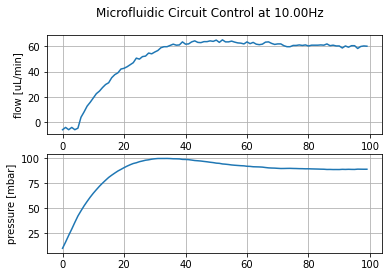

In [3]:
# Controller parameters: Very soft controller
K_p = 0.05 # <- Change this value to tune the controller
K_i = 0.1 # <- Change this value too to tune the controller
ref_flow = 60 # uL/min

p_min = 0 # <- This is only negative if you have some vacuum source
p_max = 1000 # <- This depends on the Z regulator of each channel

# OB1 arrangement
p_channel = 2 # <- Change this to
fs_channel = 2 # <- your real configuration

experiment_t = 10.0 # Seconds
flow_list = []
error_list = []
control_list = []

run()

### 2.2 SDK remote PID control
If you have previously configured any of the compatible instruments (OB1, AF1, MSRD, BFS) in remote mode, where the acquisition is run autonomously, the Elvesys SDK allows you to start or stop PID loops between these instruments without having to write the code of the loop itself. A fully working flow regulation can be started with an OB1 and an MFS with a single function call. Subsequent modification of the PID target is achieved in the remote loop of the device controlling the pressure/flow. A PID loop can be started on a single remote loop if the device can regulate the pressure/flow and a sensor is also connected to it.

The following is a summary of the necessary functions to run the remote PID controller:

| Function | Description |
| --- | --- |
| PID_Add_Remote() | Create a PID controller associated to some pressure output. |
| OB1_Start_Remote_Measurement() | Start the remote mode of the instrument. |
| OB1_Stop_Remote_Measurement() | Stop the remote mode of the instrument. |
| OB1_Get_Remote_Data() | Returns the last measure from a instrument on remote mode. |
| OB1_Set_Remote_Target() | Set a new control reference to a controlled pressure output. |

If you correctly tuned the controller in the previous step of this chapter, you should now have a set of parameters which is suitable for your current system. You can set those values in the next code cell to run the remote PI controller with them. Anyway, notice that the sampling frequency of the remote PID control is higher than the one achievable with custom external code; thus, you may need to reduce the value of your gains.


**Note.** If you need to check the usage of one function from our SDK, you can find the API reference at the SDK User Guide at any moment.


In [ ]:
# Controller parameters: Very soft controller
K_p = 0.05 # <- Change this value to tune the controller
K_i = 0.003 # <- Change this value too to tune the controller
ref_flow = 50 # uL/min

experiment_t = 5.0

# OB1 arrangement
p_channel = 2 # <- Change this to
fs_channel = 2 # <- your real configuration

# Start running the PI Control on remote mode
error = OB1_Start_Remote_Measurement(Instr_ID.value, byref(Calib), 1000)
# Start the PID Controller onsite
p_channel = c_int32( int(p_channel) ) # convert to c_int32
fs_channel = c_int32( int(fs_channel) ) # convert to c_int32
error = PID_Add_Remote(Instr_ID.value, p_channel, Instr_ID.value, fs_channel, K_p, K_i, 1) 
# Set the reference
ref_flow = c_double( float(ref_flow) )
error = OB1_Set_Remote_Target(Instr_ID.value, p_channel, ref_flow) 

flow_list = []
control_list = []
meas_flow = c_double()
control_val = c_double()

start_t = time.time() # <- This must be close to the routine
last_t = start_t
while True:
    error = OB1_Get_Remote_Data(Instr_ID.value, fs_channel, byref(control_val), byref(meas_flow))
    flow_list.append( meas_flow.value )
    control_list.append( control_val.value )

    # Check if the elapsed time match the time limit
    if (time.time() - start_t) > experiment_t:
        break
    # Wait until desired period time
    sleep_t = period - (time.time() - last_t)
    if sleep_t > 0:
        time.sleep( sleep_t )
    last_t = time.time() # And update the last time

error = OB1_Stop_Remote_Measurement(Instr_ID.value)
print('Stop. Error value: %d' % error)

# Plot the signals
plt.rcParams['axes.grid'] = True
fig=plt.figure()
fig.suptitle("Remote PID Control")

plt.subplot(2,1,1)
plt.plot( flow_list )
plt.ylabel('flow [uL/min]')
plt.subplot(2,1,2)
plt.plot( control_list )
plt.ylabel('pressure [mbar]')

## 2.3 Conclusions
In this tutorial we have seen how a simple PI Control works, how can it be implemented with the OB1 instrument, how to tune its parameters and, finally, how to use the remote PID controller.

As we saw, it is not difficult to implement a custom controller for the OB1 instrument using Python. However, the problem gets more difficult when you must perform more tasks while running the controller or if you must control several instruments at once. For those situations, it turns out way easier to use the remote PID controllers due to the fact that, once configured and launched, you only must change the reference or gather data from it whenever you need it. However remember to check that the sampling frequency matches the one of the control you used for the tuning.

Finally, if you want to keep learning about microfluidics and related topics, you can also check our [application notes](https://www.elveflow.com/microfluidic-application-notes/) (free tutorials) or [reviews](https://www.elveflow.com/microfluidic-reviews/).

Hope you found this tutorial useful, and thanks for trusting Elvesys!